# Introduction -- Reminder

Each Python lab will start with a pre-flight exercise that walks through building some of the set up and tools ($\sim$ 30 min), followed by an in-class tutorial with time for Q+A (50 min) so you can walk through steps that will be necessary for the homework assignment you will submit ($\sim$ 3 hrs).  Each lab will contain starter code, similar to what you see below.  Please fill in the code to complete the pre-flight assignment in preparation for the in-class tutorial.  

Preflight ($\sim$30-60 min, 10 points) **Typically due: Thursdays 3pm EST**

*Preflight typically graded by Wednesday 5p EST*

In-class tutorial and Q+A ($\sim$ 50 min, 10 points) **Typically occurs: Fridays EST**

Homework assignment ($\sim$ 3-5 hrs, 30 points) **Typically due: Tuesdays 12pm EST**  


When we grade your homework, we will not run your code. Once submitted, your notebook should have the outputs for all of your results.  Please do not include long outputs from debugging, beyond a few print statements and the requested visualimzations (i.e. plots).

**Grading:** When we grade your notebook, we will convert the .ipynb file to an HTML file.  We will be using [nbgrader](https://nbgrader.readthedocs.io/en/stable/) to grade your notebooks.  **Note:** Execute the cell below (click in the cell and press shift+enter, or click in the cell and press the Run button) to check that you are using a version of python that is compatible with the tool we are using to grade your assignments.  If your ```IPython``` version is too old, we will *not* be able to grade your assignments.


# Phys 260 Python Lab 2: More Python: Tutorial (20 points total)

## Tutorial summary
- Discussion of meshgrid inputs (args and kwargs) and outputs (returned values/objects). 
- Efield calculation for more than one point with `np.apply_along_axis` (two point example, extended to arbitrary number of points).
- Discretize a charge distribution (sphere example, exercise with cube example)
- Build a function to take arbitrary points, arbitrary charges, and arbitrary `points_in_meshgrid`. 
- Define the points and dq's due to a spherical insulator of charge.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time # We'll see an example of timing your code
import matplotlib.patches as patches # Utility for drawing shapes

In [2]:
#  Here we set up the points in our vector field
numpoints_1d = 10

sample_points = np.linspace(-3,3,num=numpoints_1d)

xarray, yarray, zarray = np.meshgrid(sample_points,
                                     sample_points,
                                     sample_points,
                                     indexing='ij'
                                    )

points_in_meshgrid = np.array([xarray, yarray, zarray])
sample_points.shape

(10,)

## Brief review (3 points)
**Quick questions for the class** (class discussion -- 10 min 3 points): 
- What do the first three arguments of `np.meshgrid` do?
- What happens when we switch indexing to 'xy' (or if we leave out the kwarg indexing altogether)?
- What shape should `sample_points`, `xarray`, `yarray`, `zarray`, and points_in_meshgrid have?

**Answer:**
- The first three arguments correspond to the extend and one dimensional sampled points across each axis.
- When we switch indexing to 'xy' (equivalent of leaving out the kwarg because 'xy' is the default), then the first and second dimensions switch.
- The shapes should be `(numpoints_1d,)`; `(numpoints_1d, numpoints_1d, numpoints_1d)` for all x, y, z arrays;  `points_in_meshgrid` should be `(3,numpoints_1d, numpoints_1d, numpoints_1d)`, 

## The efield calculator

In [3]:
def calculate_efield_at_point(field_position, charge_position, q=1) :
    '''Return the electric field due to a point charge.
    
    Inputs:
    field_position shape (3,) array : x, y, and z position vector for field point
    charge_position shape (3,) array : x, y, and z position vector for charge 
    q (float or int) : charge of the point

    Outputs:
    vector_efield shape (3,) array : x, y, z components of the e-field at the point field_position
    '''

    r = field_position-charge_position
    r_magnitude = np.linalg.norm(r)
    r_unit = r/r_magnitude
    
    k = 1  #  To make plotting extents easier to deal with
    
    return k*q / r_magnitude**2 * r_unit

## Finding the e-field due to a point charge

Let us recall the one line calculation for a point charge.

In [4]:
charge_position = np.array([0,0,0])
efield_vectors_for_point_charge = np.apply_along_axis(calculate_efield_at_point, 0, 
                                                         points_in_meshgrid, charge_position)

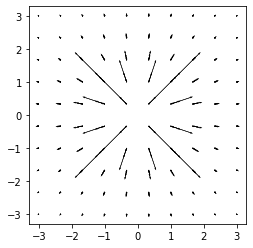

In [5]:
# Quick recall of what this looks like projected down the z-axis

# Note you can shortcut a plot with plt.<method name> to skip over defining a figure and axes. 
# However, you have less control over things like the figure size.
plt.quiver(points_in_meshgrid[0].ravel(), 
           points_in_meshgrid[1].ravel(), 
           efield_vectors_for_point_charge[0].ravel(), 
           efield_vectors_for_point_charge[1].ravel())

plt.gca().set_aspect('equal') # The set_aspect is a method of an axis, so we "get current axes", gca

**Slice of vector field**: Side note, we can also take a slice of the vector field along the xy-plane, where z=0.  You'd notice that the overlapping arrow heads are now gone (and I believe the arrow lengths are normalized to one another, so the ones closest to the center are noticeably longer). 

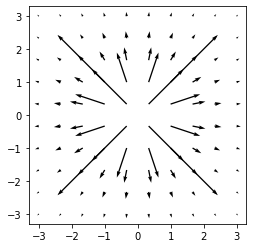

In [6]:
z_index_xy_plane = int(numpoints_1d/2) # Pick the middle z-index closest to xy-plane

# Check that this is the proper index
assert((np.abs(points_in_meshgrid[2,:,:,z_index_xy_plane])==np.min(np.abs(points_in_meshgrid[2]))).all())

plt.quiver(points_in_meshgrid[0,:,:,z_index_xy_plane].ravel(), 
           points_in_meshgrid[1,:,:,z_index_xy_plane].ravel(), 
           efield_vectors_for_point_charge[0,:,:,z_index_xy_plane].ravel(), 
           efield_vectors_for_point_charge[1,:,:,z_index_xy_plane].ravel())

plt.gca().set_aspect('equal')

## Find the e-field due to multiple point charges: loop version (6 points)

**Group Exercise** (10min -- 3 points): Assume that you have a point charge at (1,0,0) and at (-1,0,0) each with charge 0.5C.   Calculate the `efield_vectors_for_two_charges` below.  This is similar to the dipole calculation you did in the first tutorial/hw in that you will use the fact that you can add the contribution of each charge to the electric field.  
- We set up an array representing the vector field, `efield_vectors_for_two_charges`, that is initially zero everywhere using `np.zeros` [documentation](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html).  
- Then, we loop over both point charge positions.
- In the loop, you will want to use the function `calculate_efield_at_point`, incorporating the keyword argument `q=0.5`.
- Use the principle of superposition here, and fill out the for-loop. *Hint*: You'll want to add the output of the `np.apply_along_axis` call to efield_vectors_for_two_charges. The `+=` might be useful here:
```
x = 1
x += 5 # This makes the value of x be 6
```

**Class exercise** (discussion -- 5 min): Fill in the loop below. Aim to do this in 1-2 lines, see hint above. (2/6 points)

In [7]:
start = time.time() # We'll time the loop

# Define the charge positions
charge_pos_1 = np.array([1,0,0])
charge_pos_2 = np.array([-1,0,0])

# Initial array for efield is filled with zeros
efield_vectors_for_two_charges = np.zeros((3, numpoints_1d, numpoints_1d, numpoints_1d))

# Let's create an iterable of charge positions
charge_positions = [charge_pos_1, charge_pos_2]

# Calculate efield_vectors_for_two_charges here
for charge_pos in charge_positions :
### BEGIN SOLUTION
    efield_vectors_for_two_charges += np.apply_along_axis(calculate_efield_at_point, 0, 
                                                points_in_meshgrid, charge_pos, q=0.5)
### END SOLUTION

print('Loop took: ',time.time() - start, ' sec')

Loop took:  0.024068832397460938  sec


In [8]:
"""Execute to check you are on the right track"""
assert(efield_vectors_for_two_charges.shape == (3, numpoints_1d, numpoints_1d, numpoints_1d))
### BEGIN HIDDEN TESTS
assert((efield_vectors_for_two_charges != np.zeros((3, numpoints_1d, numpoints_1d, numpoints_1d))).all())
### END HIDDEN TESTS

### Setting up to do this in one step (with other functions)

You should now be able to imagine how you might numerically calculate the efield due to any discretized charge configuration.  One option is to loop over the positions over each charge element, `dq`, as we did with two discrete charges above.  Below is how we would do this avoiding any for-loops, where we now will define `efield_vectors_two_charges_along_axis`.
- First we define `calculate_efield_two_points_on_grid` with `charge_position` as the first argument

In [9]:
# Calculate efield on whole meshgrid with the charge_position as the first argument 
def calculate_efield_on_grid(charge_position, pts_in_meshgrid, dq) :
    """ Find the efield on a grid of field points due to a single charge.

    Inputs:
    charge_position (n-darray) : x, y, and z position for charge, shape (3,) 
    pts_in_meshgrid (n-darray) : x, y, and z positions for field points, shape (3,m,m,m)
    dq (float or int) : charge element value

    Outputs:
    vector_efield (n-darray) : x, y, z components of the e-field at the point field_position, shape (3,m,m,m) 

    """
    assert(charge_position.shape[0]==3)
    assert(pts_in_meshgrid.shape[0]==3)
    return np.apply_along_axis(calculate_efield_at_point, 0, 
                                pts_in_meshgrid, charge_position, q=dq)

### Test the code on two charges

Now, we *nest* our use of `np.apply_along_axis`.  

- First we create an array of all charge positions (two in this case).   

- Then, we use `np.apply_along_axis` with the function `calculate_efield_on_grid` to simultaneously calculate the efield contributions to both charges.  The resulting array, `efield_vectors_for_two_charges_along_axis` has shape (3,10,10,10,2).  
- Slicing `efield_vectors_for_two_charges_along_axis[:,:,:,:,0]` gives the d$\vec{E}$ contribution due to the first charge 
- Slicing `efield_vectors_for_two_charges_along_axis[:,:,:,:,1]` gives the d$\vec{E}$ contribution due to the second charge.

- As a side note, `efield_vectors_for_two_charges_along_axis[0,:,:,:,0]` gives the dE$_x$ contribution due to the first charge, and `efield_vectors_for_two_charges_along_axis[1,:,:,:,0]` gives the dE$_y$ contribution due to the first charge

- We want to sum all of the d$\vec{E}$'s, which vary along the fourth axis.  Recall, either the `np.sum` function, or the `sum` method of arrays, e.g. `myarray.sum()`.  You'll want to use a key word argument.

In [10]:
# Let's create an array of all charge positions
charge_pos_array = np.array(charge_positions).T # T is for transpose so we get a (3,2) instead of (2,3)
print('array of charge positions has shape: ', charge_pos_array.shape)

# Calculating all efield vectors due to all charges
efield_vectors_for_two_charges_along_axis = np.apply_along_axis(calculate_efield_on_grid, 0, 
                                                                charge_pos_array, 
                                                                pts_in_meshgrid=points_in_meshgrid, 
                                                                dq=0.5)

print("Not yet summed, the array has shape: ", efield_vectors_for_two_charges_along_axis.shape)

array of charge positions has shape:  (3, 2)
Not yet summed, the array has shape:  (3, 10, 10, 10, 2)


**Group Exercise** (5 min -- 2 points): Now, we sum along the appropriate axis (2/6 points)

In [11]:
# Sum along the appropriate axis to define summed_efield_vectors_for_two_charges below
### BEGIN SOLUTION
summed_efield_vectors_for_two_charges = efield_vectors_for_two_charges_along_axis.sum(axis=4)
### END SOLUTION

print("After summing contributions due to all charges, array has shape: ", 
      summed_efield_vectors_for_two_charges.shape)

After summing contributions due to all charges, array has shape:  (3, 10, 10, 10)


In [12]:
"""Execute to check you're on the right track"""
# Check that the loop is the same as applying along an axis
assert((efield_vectors_for_two_charges == summed_efield_vectors_for_two_charges).all())

### The function that wraps all steps

Now, we turn the above code into a function, `calculate_efield_from_charges`.  Note, this uses `calculate_efield_on_grid`, which uses `calculate_efield_at_point`.  This is the function you will want to use for the sphere and cube of charge later in this notebook.

Note, the one line in the function below has not yet summed all d$\vec{E}$ contributions.  Return the appropriately summed array, similar to what you did above. (2/6 points)

In [13]:
def calculate_efield_from_charges(charge_position_array, pts_in_meshgrid, dq) :
    """ Find the efield on a grid of field points due to a multiple charges.

    Inputs:
    charge_position_array (n-darray) : x, y, and z positions for charges, shape (3,m) 
    pts_in_meshgrid (n-darray) : x, y, and z positions for field points, shape (3,l,l,l)
    dq (float or int) : charge element value

    Outputs:
    vector_efield (n-darray) : x, y, z components of the e-field at the point field_position, shape (3,l,l,l) 
    
    """
    assert(charge_position_array.shape[0] == 3)
    efield_vectors_along_axis = np.apply_along_axis(calculate_efield_on_grid, 0, 
                                                    charge_position_array, 
                                                    pts_in_meshgrid=pts_in_meshgrid, 
                                                                dq=dq)

    ### BEGIN SOLUTION
    return efield_vectors_along_axis.sum(axis=4)
    ### END SOLUTION

In [14]:
# Let's time it!
start = time.time()
efield_to_time = calculate_efield_from_charges(charge_pos_array, 
                                                      points_in_meshgrid, dq=0.5)
print('Our function using np.apply_along_axis took: ', time.time()-start, ' sec')

Our function using np.apply_along_axis took:  0.0241239070892334  sec


In [15]:
"""Execute to check you are on the right track"""
assert((efield_to_time == efield_vectors_for_two_charges).all())

## Timing excursion -- not the main benefit of apply along axis
For only two charges, the times for me were: 
- Loop took:  0.041071414947509766  sec 
- Our function using np.apply_along_axis took:  0.045400142669677734  sec

so we didn't get a speed up.  Now, when I multiply the original `charge_positions` definition by 500 several cells up, i.e.
```
charge_positions = [charge_pos_1, charge_pos_2]*500
```
and *run everything after*.  How long did the loop vs. using the function take?

Mine was:

- Loop took:  12.683035373687744  sec
- Our function using np.apply_along_axis took:  11.76368260383606  sec

When I multiplied by 2000, I got:

- Loop took:  50.451897382736206  sec
- Our function using np.apply_along_axis took:  47.71536564826965  sec

Note - `apply_along_axis` is less for speed up than it is for **writing more concise code**.  But, this at least shows that you won't be suffering a loss.  There are ways to truly ["vectorize"](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html) your operations, and many of the numpy built in functions/methods do that (e.g. `np.sum`).  I should add, writing concise code should not come at the expense of writing readable code.  I have tried to come up with function names and variable names that illustrate what is being done at each step.  Code readability evolves with ["code review"](https://en.wikipedia.org/wiki/Code_review).  

**Alert** Make sure to change back your `charge_positions` definition to the original line (no multiplying by some large number) before turning this in.


## Discretizing a charge distribution (11 points)

Let's say that instead of a point charge, we now have a *charge distribution*.  For initial simplicity, let us consider an origin centered spherical insulator (charges are bound in place), total charge $Q=1$C, with radius r=1m.  We will discretize this sphere in a few steps:
- Discretize the volume containing the insulator with `np.meshgrid`. Let's call the output `x_volume_samples`, `y_volume_samples`, and `z_volume_samples`. 
- *Note*, the output of `np.meshgrid` gives you a cube or rectangular prism of points.  Not all of these will be in the volume of the sphere.  Think of how, if you put a sphere in a box that snugly fits around it, there will still be space between the sphere and the corners of the box.  Use `np.where` to identify the points acutally in the sphere.  
- Use `np.where` to define the variables `x_sphere_samples`, `y_sphere_samples`, and `z_sphere_samples`, where you have selected the relevant points from `x_volume_samples`, `y_volume_samples`, and `z_volume_samples` respectively.  
- You can then use these to define `points_in_sphere`, but make sure that this has shape (3, `num_points_in_sphere`)  
- Given `num_points_in_sphere`, divide the total charge Q into the number of points sampling the sphere.  Use this to define `dq_sphere` (the discretized charges).  This is a rough approximation.  

Let's first create the points that sample the volume enclosing the sphere (1/11 points)

In [16]:
# Discretize the space around the sphere, defining x_volume_samples, y_volume_samples, z_volume_samples
num_volume_pts_1d = 8
volume_points_1d = np.linspace(-1,1, num=num_volume_pts_1d)
sphere_radius = 1.

### BEGIN SOLUTION
x_volume_samples, y_volume_samples, z_volume_samples = np.meshgrid(volume_points_1d,
                                                               volume_points_1d,
                                                               volume_points_1d,
                                                               indexing='ij') 
### END SOLUTION

In [17]:
"""Execute this cell to check that you are on the right track"""
assert(x_volume_samples.shape == (num_volume_pts_1d, num_volume_pts_1d, num_volume_pts_1d))
### BEGIN HIDDEN TESTS
x_test, y_test, z_test = np.meshgrid(volume_points_1d,
                                    volume_points_1d,
                                    volume_points_1d,
                                    indexing='ij') 

assert((x_volume_samples == x_test).all())
assert((y_volume_samples == y_test).all())
assert((z_volume_samples == z_test).all())
### END HIDDEN TESTS

Use `np.where` (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.where.html)) to select points from `meshgrid_samples` that are actually in the sphere.  You can calculate the radial distance of each point with,
```
radial_distance_meshgrid_points = np.linalg.norm(np.array([x_volume_samples, 
                                                            y_volume_samples, 
                                                            z_volume_samples]), axis=0)
```
and the points in the sphere correspond to points *where* the `radial_distance_meshgrid_points <= sphere_radius`.  Let us use that criterion to define `sphere_mask`,
```
mask_criterion = radial_distance_meshgrid_points <= sphere_radius
sphere_mask = np.where(radial_distance_meshgrid_points <= sphere_radius)
```

Now, create the mask of points that identify sphere locations in the volume you just sampled (2/11 points)

In [18]:
# Create the radial_distance_meshgrid_points array here, and the sphere_mask here
### BEGIN SOLUTION
radial_distance_meshgrid_points = np.linalg.norm(np.array([x_volume_samples, 
                                                            y_volume_samples, 
                                                            z_volume_samples]), axis=0)

mask_criterion = radial_distance_meshgrid_points <= sphere_radius
sphere_mask = np.nonzero(mask_criterion)
### END SOLUTION


In [19]:
"""Execute to check you are on the right track"""
assert((radial_distance_meshgrid_points == np.linalg.norm(np.array([x_volume_samples, 
                                                            y_volume_samples, 
                                                            z_volume_samples]), axis=0)).all())
### BEGIN HIDDEN TESTS
assert((mask_criterion.shape == x_volume_samples.shape))
### END HIDDEN TESTS

Thought questions (3/11 points)
- What is the shape of `radial_distance_meshgrid_points` and the shape of `mask_criterion`?  How do their shapes and sizes compare with x_volume_samples (or y, or z)?
- What does `mask_criterion` indicate?  *Hint*: Print out to check, but delete before submission because the output will be large.
- What does the `sphere_mask` indicate? *Hint*: Google "how does numpy where work".

**Answer**:
- Both should have the same shape of x_volume_samples, ergo the same size.  Each element in `radial_distance_meshgrid_points` corresponds to the distance between the point in the meshgrid and zero (radial distance), as each element in x_volume_samples corresponds to the x-coordinate of each point in the meshgrid.  
- The `mask_criterion` is full of True of False booleans for every point in the meshgrid if it is or is not less than or equal to 0.
- The `sphere_mask` indicates the indexed locations of points in the sphere.

Now, we define `x_sphere_samples`, `y_sphere_samples`, and `z_sphere_samples`, *where* we have selected the relevant points from `x_volume_samples`, `y_volume_samples`, and `z_volume_samples`  (2/11 points)

In [20]:
# Define the x_sphere_samples, y_sphere_samples, and z_sphere_samples here
### BEGIN SOLUTION
x_sphere_samples = x_volume_samples[sphere_mask]
y_sphere_samples = y_volume_samples[sphere_mask]
z_sphere_samples = z_volume_samples[sphere_mask]
### END SOLUTION

x_sphere_samples.shape

(160,)

In [21]:
# Now, we create points_in_sphere, check that this is a 3,m shape array
points_in_sphere = np.array([x_sphere_samples, y_sphere_samples, z_sphere_samples])
print(points_in_sphere.shape)

(3, 160)


In [22]:
"""Execute to make sure you are on the right track"""
assert((np.linalg.norm(points_in_sphere, axis=0)<=sphere_radius).all())
### BEGIN HIDDEN TESTS
assert(points_in_sphere.shape[0] == 3)
### END HIDDEN TESTS

Now, define `dq_sphere`, given that the total charge is Q=1C, and you can also figure out the number of points sampling in the sphere. *Hint:* Use its shape. (2/11 points)

In [23]:
# Define dq_sphere here
### BEGIN SOLUTION
dq_sphere = 1./points_in_sphere.shape[1]
### END SOLUTION

In [24]:
"""Execute to make sure you are on the right track"""
assert(dq_sphere == 1./points_in_sphere.shape[1])

Now, you can calculate the electric field!  Define `efield_from_sphere` using the function `calculate_efield_from_charges`, your `points_in_sphere`, `points_in_meshgrid`, and the `dq_sphere` you calculated. (1/11 points)

In [25]:
# Define efield_sphere here
print(points_in_sphere[:,0])
print(points_in_sphere[:,int(1*points_in_sphere.shape[1]/8):int(2*points_in_sphere.shape[1]/8)])
### BEGIN SOLUTION
efield_from_sphere = calculate_efield_from_charges(points_in_sphere, points_in_meshgrid, dq_sphere)
### END SOLUTION

[-0.71428571 -0.42857143 -0.42857143]
[[-0.42857143 -0.42857143 -0.42857143 -0.42857143 -0.42857143 -0.42857143
  -0.42857143 -0.42857143 -0.42857143 -0.42857143 -0.42857143 -0.42857143
  -0.42857143 -0.42857143 -0.42857143 -0.42857143 -0.42857143 -0.42857143
  -0.42857143 -0.42857143]
 [-0.42857143 -0.42857143 -0.42857143 -0.42857143 -0.42857143 -0.42857143
  -0.14285714 -0.14285714 -0.14285714 -0.14285714 -0.14285714 -0.14285714
   0.14285714  0.14285714  0.14285714  0.14285714  0.14285714  0.14285714
   0.42857143  0.42857143]
 [-0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143  0.71428571
  -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143  0.71428571
  -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143  0.71428571
  -0.71428571 -0.42857143]]


In [26]:
"""Execute to check you are on the right track"""
assert(efield_from_sphere.shape == (3, numpoints_1d, numpoints_1d, numpoints_1d))

## Plotting excursion -- slicing along a plane or an axis
Below, we illustrate slicing a plane and an axis. Below is a quick version of how we've used quiver, projecting down the z-axis.

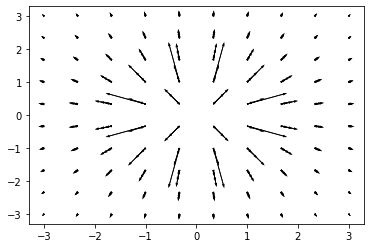

In [27]:
plt.quiver(points_in_meshgrid[0].ravel(),
        points_in_meshgrid[1].ravel(),
          efield_from_sphere[0].ravel(),
          efield_from_sphere[1].ravel())

Below, we slice along the points closest to the xy plane

Text(0, 0.5, 'y (meters)')

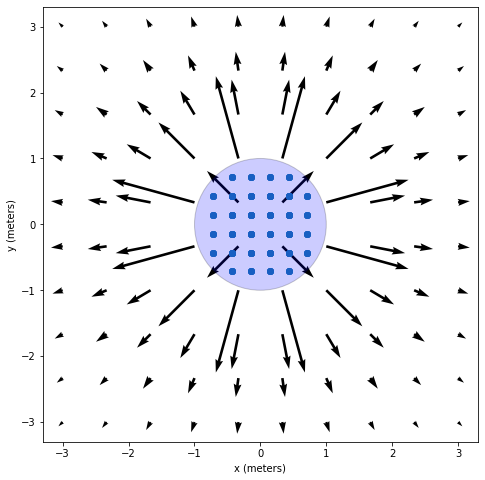

In [28]:
z_index_xy_plane = int(numpoints_1d/2) # Pick the middle z-index corresponding to xy-plane

fig, ax1 = plt.subplots(1, figsize=(8,8))
ax1.quiver(points_in_meshgrid[0,:,:,z_index_xy_plane], 
           points_in_meshgrid[1,:,:,z_index_xy_plane],  
           efield_from_sphere[0,:,:,z_index_xy_plane], 
           efield_from_sphere[1,:,:,z_index_xy_plane])

# Illustrate sampled sphere
ax1.scatter(points_in_sphere[0], points_in_sphere[1])

# Draw the actual sphere - just to illustrate in solutions
sphere = patches.Circle((0,0),radius=sphere_radius, edgecolor='k', facecolor='b', alpha=0.2)
ax1.add_patch(sphere) 
ax1.set_aspect('equal')    # forces axes to have same scale
ax1.set_xlabel('x (meters)')
ax1.set_ylabel('y (meters)')

Here, we show an alternative visualization, with the `streamplot` method.  **Note**: Streamplot expects 'xy' indexing, so you'll have to switch the order of the efield.

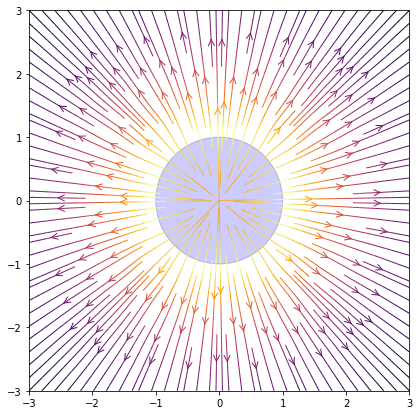

In [29]:
fig, ax1 = plt.subplots(1,1, figsize=(7,7))
efield_magnitude = np.linalg.norm(efield_from_sphere, axis=0)
colors = 2 * np.log(efield_magnitude)    # colors the arrows based on field strength

ax1.streamplot(sample_points, sample_points,  
               efield_from_sphere[1,:,:,z_index_xy_plane], efield_from_sphere[0,:,:,z_index_xy_plane], 
              color=colors[:,:,z_index_xy_plane], linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)
ax1.set_aspect('equal')

# Draw the sphere:
ball = patches.Circle((0,0),radius=1, edgecolor='k', facecolor='b', alpha=0.2)
ax1.add_patch(ball)

For fun, we build a line of charge across the diagonal on the xy-plane.  This should be reminiscent of the previous homework.

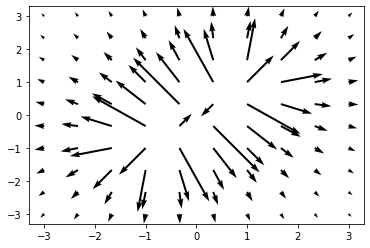

In [30]:
efield_point_function = calculate_efield_from_charges(np.array([[.5,.5,0],[1,1,0],[0,0,0],[-1,-1,0],[-.5,-.5,0]]).T, points_in_meshgrid, 1)
plt.quiver(points_in_meshgrid[0,:,:,z_index_xy_plane], 
           points_in_meshgrid[1,:,:,z_index_xy_plane],  
           efield_point_function[0,:,:,z_index_xy_plane], 
           efield_point_function[1,:,:,z_index_xy_plane])

# Phys 260 Python Lab 2: More Python: Homework (10 points total)


Your homework assignment begins here.  Note, the homework below relies on code built during the tutorial (above)

## Homework summary
- Key Tasks: Define charge points and dq for a cube
- Visualize the field on two planes

## Discretize a cube charge distribution (5 points)
Go through the *same* steps as what we did for the spherical distribution to discretize the charge distribution.  Note, however, that you will *not* have to use the `np.where` statement if you specify points already in the cube as the `points_in_cube`.  Let us do this for an origin centered cube, total charge $Q=1$C, whose volume lies within $-1.25\leq x,y,z\leq 1.25$.

- First, define your sample points, `cube_sample_points` to span only the extent of the cube, and let's sample 10 points across again.  Use `cube_sample_points` as the `np.meshgrid` arguments.  Use the output of `np.meshgrid`, `x_cube_points`, `y_cube_points`, and `z_cube_points`. 
- Ravel each of the outputs so you can define `points_in_cube` that is of shape (3,n).  Note, `points_in_cube` should be a single array comprised of the outputs of `np.meshgrid`.

First, define the x, y, z points of the cube (2/5 points)

In [31]:
# Define x_cube_points, y_cube_points, z_cube_points here 
num_cube_points_1d = 10
cube_width = 2.5
cube_sample_points = np.linspace(-cube_width/2, cube_width/2,num=num_cube_points_1d)
### BEGIN SOLUTION
x_cube_points, y_cube_points, z_cube_points = np.meshgrid(cube_sample_points,
                                                cube_sample_points,
                                                cube_sample_points,
                                                indexing='ij')
### END SOLUTION

In [32]:
"""Execute to make sure you are on the right track"""
assert(x_cube_points.shape == (num_cube_points_1d, num_cube_points_1d, num_cube_points_1d))
### BEGIN HIDDEN TESTS
assert((x_cube_points == np.meshgrid(cube_sample_points,
                                                cube_sample_points,
                                                cube_sample_points,
                                                indexing='ij')[0]).all())
### END HIDDEN TESTS

Now, define `points_in_cube` such that you can use the function `calculate_efield_from_charges`.  You may want to first ravel each of the meshgrid outputs, then put them into an array. (2/5 points)

In [33]:
# Define points_in_cube such that it is shape 3,n
### BEGIN SOLUTION
points_in_cube = np.array([x_cube_points.ravel(),
                          y_cube_points.ravel(),
                          z_cube_points.ravel()])
### END SOLUTION

In [34]:
"""Execute to make sure you are on the right track"""
assert(points_in_cube.shape == (3, num_cube_points_1d**3))
### BEGIN HIDDEN TESTS
assert((points_in_cube == np.array([x_cube_points.ravel(),
                          y_cube_points.ravel(),
                          z_cube_points.ravel()])).all()
)
### END HIDDEN TESTS

Define `dq_cube` here in terms of the shape of `points_in_cube`. (1/5 points)

In [35]:
# Define dq_cube here
Q = 1.
### BEGIN SOLUTION
dq_cube = Q / points_in_cube.shape[1]
### END SOLUTION

In [36]:
"""Execute to make sure you are on the right track"""
assert(type(dq_cube) == float)
### BEGIN HIDDEN TESTS
assert(dq_cube == Q / points_in_cube.shape[1])
### END HIDDEN TESTS

## Calculate the efield due to the cube (1 point)

Use the function we defined in the tutorial to calculate the efield, `efield_cube_insulator`.  Note, you'll need `points_in_cube` and you `dq_cube` as new arguments (you'll still need `points_in_meshgrid`).

In [37]:
# Define efield_cube_insulator here
### BEGIN SOLUTION
efield_cube_insulator = calculate_efield_from_charges(points_in_cube, 
                                                      points_in_meshgrid, dq=dq_cube)
### END SOLUTION

In [38]:
"""Execute to check that you're on the right track"""
assert(efield_cube_insulator.shape == (3, num_cube_points_1d, num_cube_points_1d, num_cube_points_1d))

## Visualize the efield due to a cube charge (2 points)

Use the `quiver` method to visualize the efield.  Let us do this: 
- For the slice of 2d space that is closest to the xy-plane (e.g. z=0).
- For the slice of 2d space that is parallel to the xy-plane, but on the top edge of our sampled meshgrid points (e.g. $z=3$m)

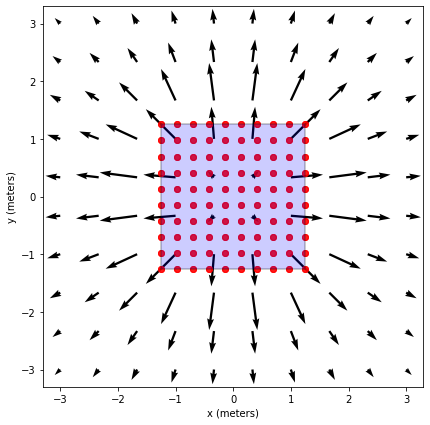

In [39]:
#  Use the quiver plot to visualize the efield on the xy plane
fig, ax = plt.subplots(1,1,figsize=(7,7))

### BEGIN SOLUTION
z_index_xy_plane = int(points_in_meshgrid.shape[-1]/2)
ax.quiver(points_in_meshgrid[0,:,:,z_index_xy_plane], points_in_meshgrid[1,:,:,z_index_xy_plane],
          efield_cube_insulator[0,:,:,z_index_xy_plane], efield_cube_insulator[1,:,:,z_index_xy_plane])
### END SOLUTION

# Here, we overplot the cube itself
square = patches.Rectangle((-cube_width/2,-cube_width/2),cube_width,cube_width,linewidth=1,edgecolor='k',lw=2, facecolor='b', alpha=0.2)
ax.add_patch(square)
ax.set_aspect('equal')
ax.set_xlabel('x (meters)')
ax.set_ylabel('y (meters)')

# Here, we overplot the points sampling the cube
ax.scatter(points_in_cube[0], points_in_cube[1], alpha=.2, color='r')

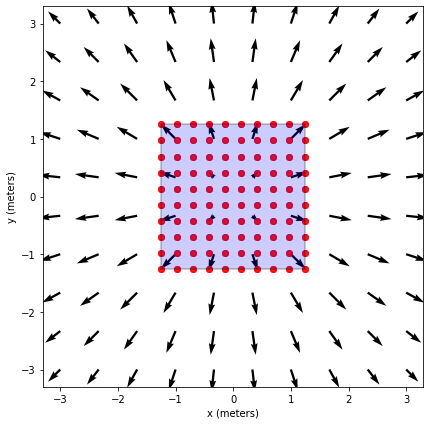

In [40]:
#  Use the quiver plot to visualize the efield on z=-3m
#  Use the quiver plot to visualize the efield on the xy plane
fig, ax = plt.subplots(1,1,figsize=(7,7))

### BEGIN SOLUTION
z_index_top_plane = -1
ax.quiver(points_in_meshgrid[0,:,:,z_index_top_plane], points_in_meshgrid[1,:,:,z_index_top_plane],
          efield_cube_insulator[0,:,:,z_index_top_plane], efield_cube_insulator[1,:,:,z_index_top_plane])
### END SOLUTION

# Here, we overplot the cube itself
square = patches.Rectangle((-cube_width/2,-cube_width/2),cube_width,cube_width,linewidth=1,edgecolor='k',lw=2, facecolor='b', alpha=0.2)
ax.add_patch(square)
ax.set_aspect('equal')
ax.set_xlabel('x (meters)')
ax.set_ylabel('y (meters)')

# Here, we overplot the points sampling the cube
ax.scatter(points_in_cube[0], points_in_cube[1], alpha=.2, color='r')

## Description question (1 points): 

What is the qualitative difference in the vector field between both planes?  (How do they differ, and why?)

**Answer**: 

On the xy-plane, the field lines increase in magnitude from the center to the edge of the cube because more "charge is enclosed".  On the $z=3$ plane, they point away from the screen for field points above the cube, so they look smaller.

## Think about the cube setup (1 points)

**Open question**: Can we do this with Gauss' law?  Why or why not?

**Answer:**
We cannot to this with Gauss' law because it lacks the symmetry required for a nice Gaussian surface.  The edges pretty much ruin the E dot dA. 